In [1]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
import h5py
import cv2
import os
import os
import sys
import time

from skimage.color import label2rgb
import SimpleITK as sitk
import openslide
import skimage

from keras.applications import VGG16
from keras.applications.resnet50 import ResNet50
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import decode_predictions
%pylab inline

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


In [2]:
from scipy.spatial import distance as dist
import copy
from scipy.io import loadmat
from keras.optimizers import SGD
from keras.callbacks import *
from skimage import data, img_as_float
from skimage.measure import compare_ssim as ssim

In [3]:
def transfer_roi(im_src, im_dst, dst_img):
    """
    Transfer the region of interest from source image to destination image and save image to dst_img
    
    Parameters
    ----------
    im_src: ndarray
             3-channel source image containing region of interest with a particular pixel value
             
    im_dst: ndarray
             2-channel/3-channel destnation image where roi is to be transfered from source image,
             same shape as of src_image
             
    dst_img: str
             Filename of the infrared image with roi
           
    Returns
    -------
    3-channel image with the roi
    
    """
    
    # get the pixel value and the location of the roi
    roi_pos = np.where(im_src[:,:,2] == 255)
    
    #get the list of the x and y coordinates of the location of roi
    x = list(roi_pos[0])
    y = list(roi_pos[1])
    
    dst_with_roi = copy.deepcopy(im_dst)
    dst_with_roi[x, y] = [0,0,255]
    
    marked_folder_roi =  'E:\\transfer_roi\\ir\\marked'
    marked_path = os.path.join(marked_folder_roi, dst_img)
    
    if not os.path.exists(marked_path):
        cv2.imwrite(marked_path, dst_with_roi)
    
    return dst_with_roi

In [4]:
reg_with_roi = cv2.imread('E:\\transfer_roi\\result\\registered\\marked\\43849A_sec1.tif')
ir_img_name = '43849A_sec1.tif'

reg_unmarked = cv2.imread('E:\\transfer_roi\\result\\registered\\unmarked\\43849A_sec1.tif')
ir_unmarked =  cv2.imread('E:\\transfer_roi\\ir\\unmarked_resized\\43849A_sec1.png')
print(reg_with_roi.shape, reg_unmarked.shape, ir_unmarked.shape)

(5677, 7372, 3) (5677, 7372, 3) (5677, 7372, 3)


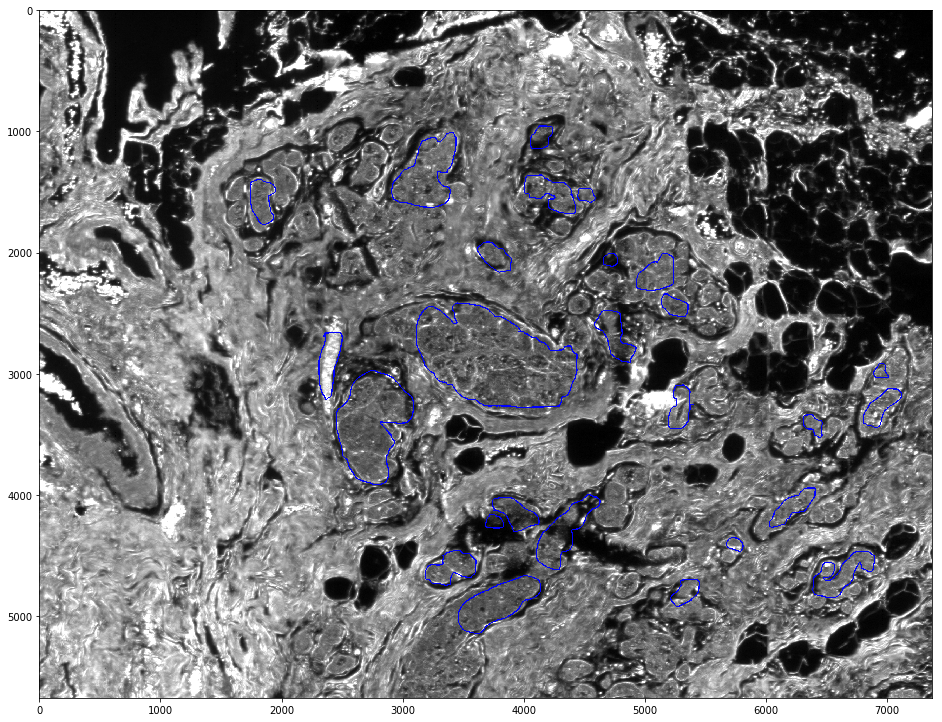

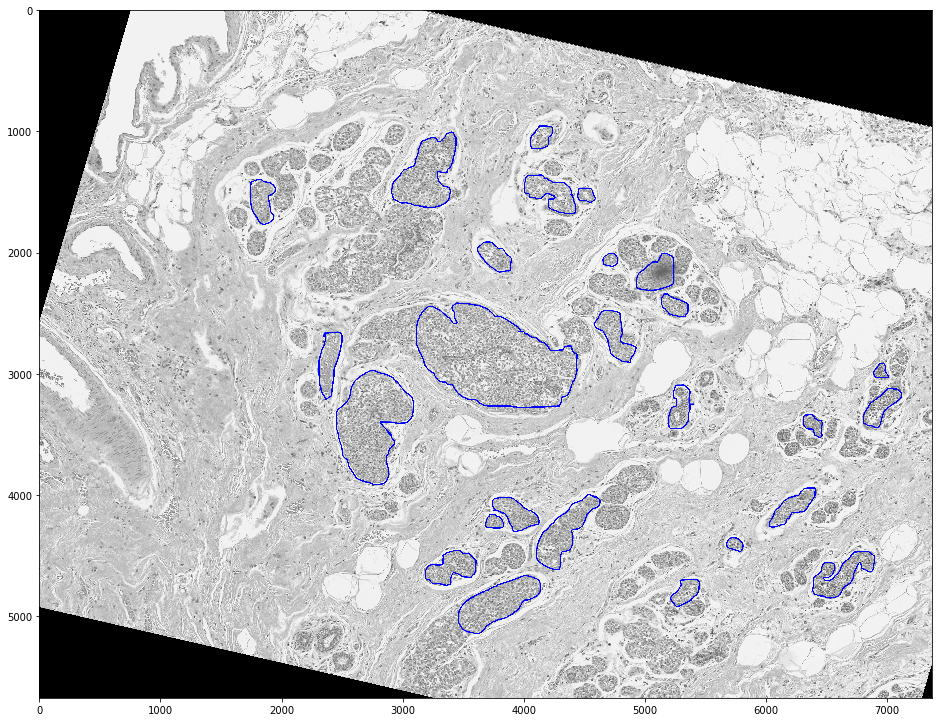

In [5]:
ir_with_roi = transfer_roi(reg_with_roi, ir_unmarked, ir_img_name)
plt.figure(figsize = (16,16))
plt.imshow(ir_with_roi, cmap = 'gray')
plt.figure(figsize = (16,16))
plt.imshow(reg_with_roi, cmap = 'gray')

In [6]:
def extract_roi(reg_with_roi, ir_with_roi, reg_unmarked, ir_unmarked):
    
    """
    Extract the roi from registered and infrared image and store them in the seperate list to further
    process them using differet methods - cnn, histogram, chisquared_distance
    
    Parameters
    ----------
    reg_with_roi: ndarray
                  3-channel registered image containing region of interest with a particular pixel value
             
    ir_with_roi: ndarray
                 3-channel infra-red image containing region of interest transfered from registered image
                 
    reg_unmarked: ndarray
                  3-channel/2-channel registered image not containing region of interest with a particular pixel value
             
    ir_unmarked: ndarray
                 3-channel/2-channel infra-red image not containing region of interest transfered from registered image
             
             
    Returns
    -------
    reg_roi_list - Lists of extracted roi - 3-channel roi from registered image
    reg_roi_list - Lists of extracted roi - 3-channel roi from infrared image
    masks - mask for the each regions of interest
    """
    roi_pos = np.where( reg_with_roi[:,:,2] == 255 ) 
    
    x = list(roi_pos[0])
    y = list(roi_pos[1])
    
    #make a 2-d mask
    
    mask = np.zeros_like(reg_with_roi[:,:,1])
    mask[x,y] = 255
    
    _, cntrs = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[:2]

    reg_roi_list = []
    ir_roi_list = []
    
    #masks = []
    for  cnt in cntrs:
        
        if reg_unmarked.ndim == 3:
            reg_unmarked = cv2.cvtColor(reg_unmarked, cv2.COLOR_BGR2GRAY)
            
        if ir_unmarked.ndim == 3:
            ir_unmarked = cv2.cvtColor(ir_unmarked, cv2.COLOR_BGR2GRAY)
            
        temp_mask = np.zeros_like(reg_unmarked)
        cv2.fillPoly(temp_mask, [cnt], (255,255,255))
        #masks.append(temp_mask)
        
        reg_roi = cv2.bitwise_and(temp_mask, reg_unmarked)
        ir_roi = cv2.bitwise_and(temp_mask, ir_unmarked)
        
        x, y, w, h = cv2.boundingRect(cnt)
        reg_roi = reg_roi[y:y+h, x:x+w]
        ir_roi =  ir_roi[y:y+h, x:x+w]
        
        reg_roi_list.append(reg_roi)
        ir_roi_list.append(ir_roi)
        
    return reg_roi_list, ir_roi_list, cntrs

In [8]:
reg_l, ir_l, _ = extract_roi(reg_with_roi, ir_with_roi, reg_unmarked, ir_unmarked)
len(reg_l) == len(ir_l)

True

In [9]:
def update_model(train_dir, image_size = 224, batch_size = 8, epochs = 2):
    
    """ Update the weight of the model after new images are being added to the datasets"""
    
    # Create a data generator and specify
    # the parameters for augmentation
    train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
    
    # create an iterator for data generator
    # and autment the images
    
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size= batch_size,
        class_mode='categorical')
    
    #load pretrained model
    model = models.load_model('vgg16_finetuned.h5')
    
    # Compile the pretrained model in order to update its weight
    model.compile(loss='categorical_crossentropy',
                  optimizer = optimizers.RMSprop(lr=1e-4),
                  metrics=['acc'])
    
    # use keras checkpoint to update the model weight
    file_path = 'vgg16_finetuned.h5'
    checkpoint = ModelCheckpoint(file_path)
    callbacks_list = [checkpoint]
    
    # Train the model to update model weight
    history = model.fit_generator(
          train_generator,
          steps_per_epoch = train_generator.samples/train_generator.batch_size,
          epochs = epochs,
          callbacks = callbacks_list)

In [10]:
train_dir = "E:\\transfer_roi\\cnn_rejection\\train"

In [74]:
update_model(train_dir, epochs = 5)

Found 52 images belonging to 2 classes.
Epoch 1/5
7/6 [================================] - 37s 5s/step - loss: 0.3622 - acc: 0.9279
Epoch 2/5
7/6 [================================] - 34s 5s/step - loss: 0.3025 - acc: 0.9459
Epoch 3/5
7/6 [================================] - 35s 5s/step - loss: 0.0722 - acc: 0.9820
Epoch 4/5
7/6 [================================] - 34s 5s/step - loss: 0.1116 - acc: 0.9459
Epoch 5/5
7/6 [================================] - 34s 5s/step - loss: 0.0969 - acc: 0.9459


In [89]:
def reject_and_save_roi_cnn(reg_with_roi, reg_unmarked,  ir_with_roi, ir_unmarked):
    
    """
    Reject unclear and distorted roi's from IR image using cnn and save them to 
    cnn-training forlder for further learning process based on their class
    
    Parameters
    ----------
    reg_with_roi: ndarray
             3-channel registered image containing region of interest with a particular pixel value
             
    ir_with_roi: ndarray
                 3-channel infra-red image containing region of interest transfered from registered image   
                 
    reg_unmarked: ndarray
                  3-channel/2-channel registered image not containing region of interest 
             
    ir_unmarked: ndarray
                 3-channel/2-channel infra-red image not containing region of interest 
             
                    
    cnn_folder: str
                path for the directory where extracted images is to be saved
             
    Returns
    -------
    IR image free from distorted roi 
    
    """
    reg_list, ir_list, cntrs = extract_roi(reg_with_roi, ir_with_roi, reg_unmarked, ir_unmarked)
    
    model = models.load_model('vgg16_finetuned.h5')
    
    """
    idx = 1
    plt.figure(figsize = (8,48))
    for r, i in zip(reg_list, ir_list):
        plt.subplot(26,2,idx)
        if(idx == 1):
            plt.title('reg')
        plt.imshow(r, cmap = 'gray')
        idx+=1
        plt.subplot(26,2,idx)
        if(idx == 2):
            plt.title('ir')
        plt.imshow(i, cmap = 'gray')
        idx+=1
    
    """
    
    img = copy.deepcopy(ir_unmarked)
    idx = 0
    for ir_img, reg_img, cnt in zip(ir_list, reg_list, cntrs):
        ir_img = cv2.resize(ir_img, (224,224), cv2.INTER_NEAREST)
        ir_img1 = skimage.color.grey2rgb(ir_img)
        ir_img = np.reshape(ir_img1, (1, 224,224,3))
        
        #make prediction from model
        pred1 = model.predict(ir_img)
        pred = np.argmax(pred1)
        
        #print(pred1)
        # pred = 0 -> deformed image, pred = 1 -> undeformed ir or h&e image
        
        if(pred == 1):
            cv2.drawContours(img, [cnt], 0, (0,0, 255), 10)
        if(pred == 0):
            print('Transfered roi with index {0} on IR image is deformed'.format(idx))
            #fn = os.path.join(cnn_folder, '{}.png'.format(idx))
            #cv2.imwrite(fn, ir_img1)
        idx += 1
    return img

In [46]:
ir_final_folder = r'E:\transfer_roi\cnn_rejection\final_image'
ir_img_name = '43028A_sec1.tif'

reg_with_roi = cv2.imread('E:\\transfer_roi\\result\\registered\\marked\\43028A_sec1.tif')
reg_unmarked = cv2.imread('E:\\transfer_roi\\result\\registered\\unmarked\\43028A_sec1.tif')
ir_unmarked =  cv2.imread('E:\\transfer_roi\\ir\\unmarked_resized\\43028A_sec1.tif')
print(reg_with_roi.shape, reg_unmarked.shape, ir_unmarked.shape)

(4007, 5930, 3) (4007, 5930, 3) (4007, 5930, 3)


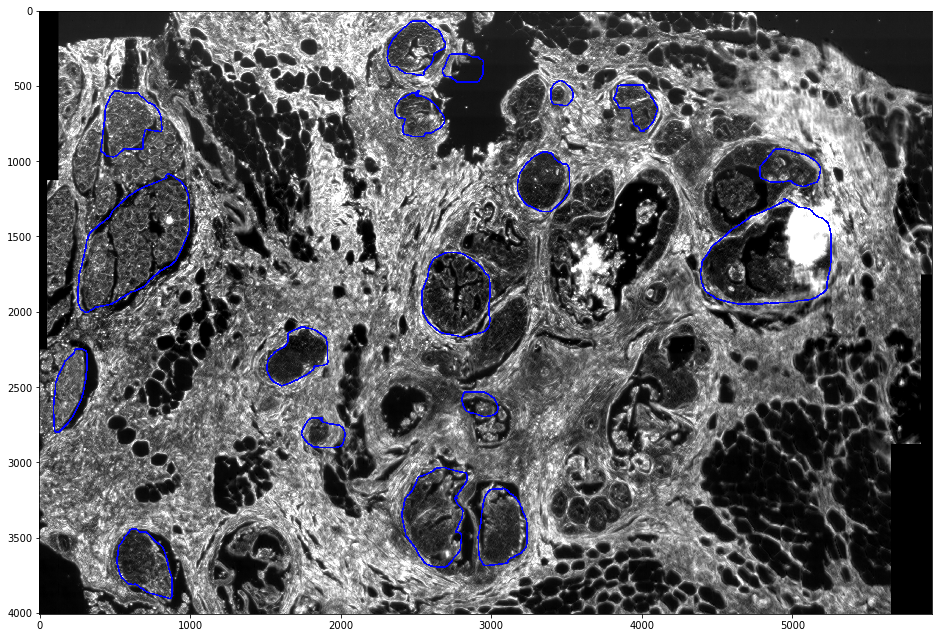

In [95]:
img = reject_and_save_roi_cnn(reg_with_roi, reg_unmarked,  ir_with_roi, ir_unmarked)
file_name = os.path.join(ir_final_folder, ir_img_name)
cv2.imwrite(file_name, img)
plt.figure(figsize = (16,16))
plt.imshow(img, cmap = 'gray')

In [96]:
ir_final_folder = r'E:\transfer_roi\cnn_rejection\final_image'
ir_img_name = '43849A_sec1.tif'

reg_with_roi = cv2.imread('E:\\transfer_roi\\result\\registered\\marked\\43849A_sec1.tif')
reg_unmarked = cv2.imread('E:\\transfer_roi\\result\\registered\\unmarked\\43849A_sec1.tif')
ir_unmarked =  cv2.imread('E:\\transfer_roi\\ir\\unmarked_resized\\43849A_sec1.png')
print(reg_with_roi.shape, reg_unmarked.shape, ir_unmarked.shape )

(5677, 7372, 3) (5677, 7372, 3) (5677, 7372, 3)


Transfered roi with index 4 on IR image is deformed
Transfered roi with index 5 on IR image is deformed
Transfered roi with index 9 on IR image is deformed
Transfered roi with index 13 on IR image is deformed
Transfered roi with index 14 on IR image is deformed
Transfered roi with index 19 on IR image is deformed
Transfered roi with index 21 on IR image is deformed
Transfered roi with index 25 on IR image is deformed


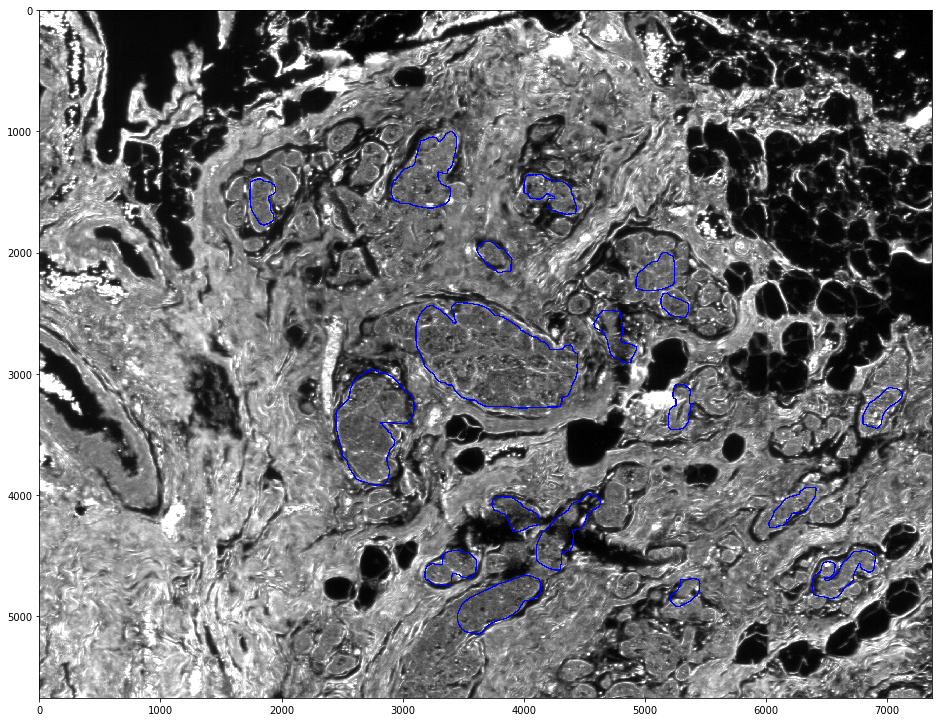

In [97]:
img = reject_and_save_roi_cnn(reg_with_roi, reg_unmarked,  ir_with_roi, ir_unmarked)

file_name = os.path.join(ir_final_folder, ir_img_name)
cv2.imwrite(file_name, img)
plt.figure(figsize = (16,16))
plt.imshow(img, cmap = 'gray')

## Histogram Based rejection

In [29]:
def mse(imageA, imageB):
    # the 'Mean Squared Error' between the two images is the
    # sum of the squared difference between the two images;
    # NOTE: the two images must have the same dimension
    
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    
    # return the MSE, the lower the error, the more "similar"
    # the two images 
    return err

In [49]:
def reject_and_save_roi_ssim(reg_with_roi, reg_unmarked,  ir_with_roi, ir_unmarked, thresh = 0.25):
    """
    Reject the ROI with SSIM greater than thresh value
    
    Parameters
    ----------
    reg_with_roi: ndarray
             3-channel registered image containing region of interest with a particular pixel value
             
    ir_with_roi: ndarray
                 3-channel infra-red image containing region of interest transfered from registered image   
                 
    reg_unmarked: ndarray
                  3-channel/2-channel registered image not containing region of interest 
             
    ir_unmarked: ndarray
                 3-channel/2-channel infra-red image not containing region of interest 
             
                    
    cnn_folder: str
                path for the directory where extracted images is to be saved
             
    Returns
    -------
    IR image free from distorted roi and list of ssim for each ROI
    
    """
    
    reg_list, ir_list, cntrs = extract_roi(reg_with_roi, ir_with_roi, reg_unmarked, ir_unmarked)
    
    ss_hist = []
    mse_val = []
    
    idx = 1
    #plt.figure(figsize = (8,48))
    
    img = copy.deepcopy(ir_unmarked)
    
    for reg, ir, cnt in zip(reg_list, ir_list, cntrs):
        reg_equalized = cv2.equalizeHist(reg)
        ir_equalized = cv2.equalizeHist(ir)
        
        ssim_value  = ssim(reg_equalized, ir_equalized)
        ss_hist.append(ssim_value)
        

        #mse1 = mse(reg_equalized, ir_equalized)
        #mse_val.append(mse1)
        
        #print(mse1, ssim_value)
        
        
        """
        plt.subplot(26,2,idx)
        if(idx == 1):
            plt.title('reg')
        plt.imshow(reg, cmap = 'gray')
        idx+=1
        plt.subplot(26,2,idx)
        if(idx == 2):
            plt.title('ir')
        plt.imshow(ir, cmap = 'gray')
        idx+=1
        
        """
        if ssim_value > thresh:
            cv2.drawContours(img, [cnt], 0, (0,0, 255), 10)
        
    return ss_hist, img   

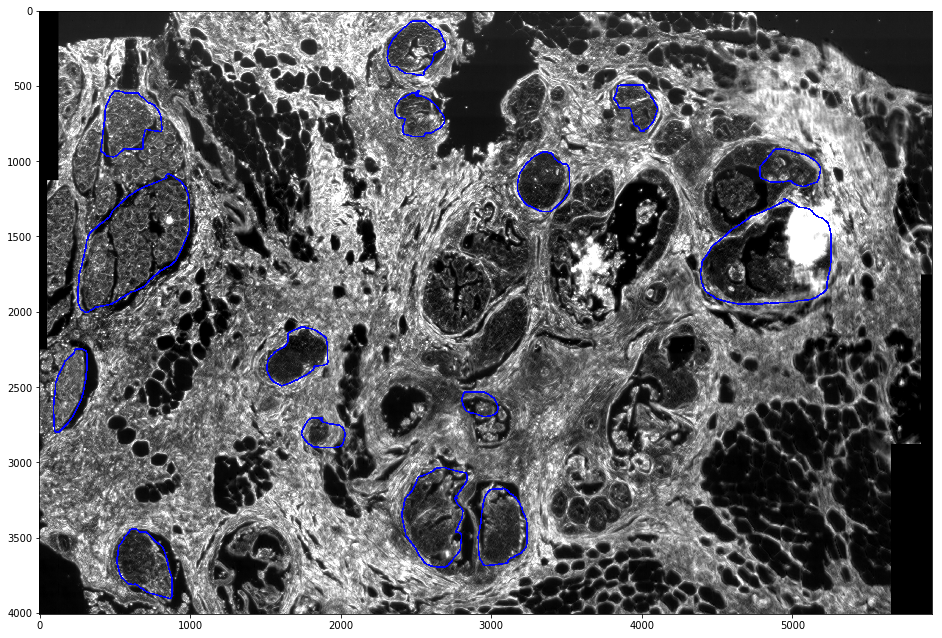

In [61]:
thresh = 20
ss_hist, img = reject_and_save_roi_ssim(reg_with_roi, reg_unmarked,  ir_with_roi, ir_unmarked, thresh/100)
file = r'E:\transfer_roi\hist_rejection\ssim_43028A_sec1_{}.tif'.format(thresh)
cv2.imwrite(file, img)
plt.figure(figsize = (16,16))
plt.imshow(img, cmap = 'gray')

In [62]:
def calc_hist(reg_img_list, ir_img_list):
    """ Returns the list of histogram of registered and infrared image patches"""
    h_ir = []
    h_reg = []
    for r, i in zip(reg_img_list, ir_img_list):
        h1 = cv2.calcHist(r, [0], None, [256], [0,256])
        h1 = cv2.normalize(h1, h1).flatten()
        h_reg.append(h1)

        #i1 = cv2.bitwise_not(r)
        h11 = cv2.calcHist(i, [0], None, [256], [0,256])
        h11 = cv2.normalize(h11, h11).flatten()
        h_ir.append(h11)
    return h_reg, h_ir

In [63]:
h_reg, h_ir = calc_hist(reg_l, ir_l)
len(h_reg)

26

In [64]:
def reject_and_save_roi_hist(reg_with_roi, reg_unmarked,  ir_with_roi, ir_unmarked, method, thresh = 0.25, cmp_mode = 'l'):

    """
    Reject the ROI with SSIM greater than thresh value
    
    Parameters
    ----------
    reg_with_roi: ndarray
             3-channel registered image containing region of interest with a particular pixel value
             
    ir_with_roi: ndarray
                 3-channel infra-red image containing region of interest transfered from registered image   
                 
    reg_unmarked: ndarray
                  3-channel/2-channel registered image not containing region of interest 
             
    ir_unmarked: ndarray
                 3-channel/2-channel infra-red image not containing region of interest 
             
                    
    cnn_folder: str
                path for the directory where extracted images is to be saved
    
    cmp_mode: char
              mode for comparison, 'l' -> less is good
              'm' -> more is good
    Returns
    -------
    IR image free from distorted roi and list of ssim for each ROI
    
    """
    
    reg_list, ir_list, cntrs = extract_roi(reg_with_roi, ir_with_roi, reg_unmarked, ir_unmarked)
    h_reg, h_ir = calc_hist(reg_list, ir_list)
    
    results = []
    
    #idx = 1
    #plt.figure(figsize = (8,48))
    
    img = copy.deepcopy(ir_unmarked)
    
    for h1, h2, cnt in zip(h_reg, h_ir, cntrs):
        
        h1 = cv2.equalizeHist(h1)
        h2 = cv2.equalizeHist(h2)
        
        dist  = cv2.compareHist(h1, h2, method)
        results.append(dist)
        

        #mse1 = mse(reg_equalized, ir_equalized)
        #mse_val.append(mse1)
        
        #print(mse1, ssim_value)
        
        
        """
        plt.subplot(26,2,idx)
        if(idx == 1):
            plt.title('reg')
        plt.imshow(reg, cmap = 'gray')
        idx+=1
        plt.subplot(26,2,idx)
        if(idx == 2):
            plt.title('ir')
        plt.imshow(ir, cmap = 'gray')
        idx+=1
        
        """
        if dist > thresh and cmp_mode == 'm':
            cv2.drawContours(img, [cnt], 0, (0,0, 255), 10)
            
        if dist < thresh and cmp_mode == 'l':
            cv2.drawContours(img, [cnt], 0, (0,0, 255), 10)
        
    return results, img   

[0.11672179839434285, 0.09622504415684202, 0.23542992974119392, 0.4361729033887519, 0.6287816373819394, 0.3325950540687461, 0.1719204765183741, 0.3126987777051907, 0.08314109954213035, 0.11593472389077543, 0.2984634993339526, 0.3035360538631301, 0.14204479339675516, 0.12290541095780769, 0.18537600202424925, 0.16552117610852835, 0.20965696489401636, 0.20931897385115092]


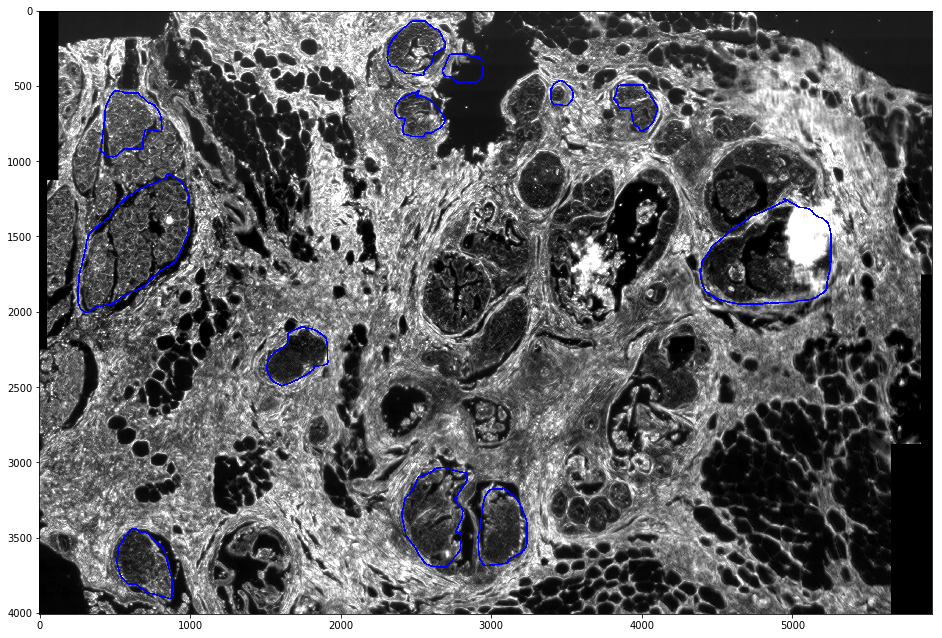

In [67]:
#methods = [cv2.HISTCMP_CORREL, cv2.HISTCMP_CHISQR, cv2.HISTCMP_INTERSECT, cv2.HISTCMP_BHATTACHARYYA ]
# cv2.HISTCMP_CHISQR and cv2.HISTCMP_BHATTACHARYYA -  minimum is the better other two reverse
method = cv2.HISTCMP_BHATTACHARYYA
results, img = reject_and_save_roi_hist(reg_with_roi, reg_unmarked,  ir_with_roi, 
                                        ir_unmarked, method = cv2.HISTCMP_BHATTACHARYYA, thresh = 0.25, cmp_mode = 'l')

print(results)
plt.figure(figsize = (16,16))
plt.imshow(img, cmap = 'gray')

In [ ]:
def reject_and_save_roi_cnn(reg_with_roi, reg_unmarked,  ir_with_roi, ir_unmarked):
    
    """
    Reject unclear and distorted roi's from IR image using cnn and save them to 
    cnn-training forlder for further learning process based on their class
    
    Parameters
    ----------
    reg_with_roi: ndarray
             3-channel registered image containing region of interest with a particular pixel value
             
    ir_with_roi: ndarray
                 3-channel infra-red image containing region of interest transfered from registered image   
                 
    reg_unmarked: ndarray
                  3-channel/2-channel registered image not containing region of interest 
             
    ir_unmarked: ndarray
                 3-channel/2-channel infra-red image not containing region of interest 
             
                    
    cnn_folder: str
                path for the directory where extracted images is to be saved
             
    Returns
    -------
    IR image free from distorted roi 
    
    """
    reg_list, ir_list, cntrs = extract_roi(reg_with_roi, ir_with_roi, reg_unmarked, ir_unmarked)
    
    img = copy.deepcopy(ir_unmarked)
    #idx = 0
    for ir_img, reg_img, cnt in zip(ir_list, reg_list, cntrs):
        ir_img = cv2.resize(ir_img, (224,224), cv2.INTER_NEAREST)
        ir_img1 = skimage.color.grey2rgb(ir_img)
        ir_img = np.reshape(ir_img1, (1, 224,224,3))
        
        #make prediction from model
        pred1 = model.predict(ir_img)
        pred = np.argmax(pred1)
        
        #print(pred1)
        # pred = 0 -> deformed image, pred = 1 -> undeformed ir or h&e image
        
        if(pred == 1):
            cv2.drawContours(img, [cnt], 0, (0,0, 255), 10)
        if(pred == 0):
            print('Transfered roi with index {0} on IR image is deformed'.format(idx))
            #fn = os.path.join(cnn_folder, '{}.png'.format(idx))
            #cv2.imwrite(fn, ir_img1)
        #idx += 1
    return img

In [69]:
path1 = 'E:\\results\\registered\\compare'
i = 0
for reg, ir in zip(reg_l, ir_l):
    
    f1 = os.path.join(path1, str(i) + "reg.png")
    f2 = os.path.join(path1, str(i) + "ir.png")
    
    cv2.imwrite(f1, reg)
    cv2.imwrite(f2, ir)
    i += 1